In [59]:
import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [60]:
data_df = pd.read_csv('data/prepared_data_pandas')

In [61]:
y_df = data_df['label']
X_df = data_df.drop('label', axis=1)

### нормализация

с ней точность хуже, поэтому не применяем

In [ ]:
from sklearn.preprocessing import normalize
X = normalize(X, norm='l2')

In [63]:
from sklearn.model_selection import train_test_split

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.33, random_state=42)

### Scikit

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

log_reg = LogisticRegression(penalty="l1") # l2 - приводит в локальный минимум
rf = RandomForestClassifier()
nb = GaussianNB()

In [8]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(rf, X_df, y_df).mean())
print(cross_val_score(log_reg, X_df, y_df).mean())
print(cross_val_score(nb, X_df, y_df).mean())

0.737278702164
0.802999906641
0.688659710545


In [10]:
rf.fit(X_train_df, y_train_df)
log_reg.fit(X_train_df, y_train_df)
nb.fit(X_train_df, y_train_df)

GaussianNB(priors=None)

In [17]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def get_accuracy(pred, y_test):
    count_corr = 0
    for i in zip(y_test, pred):
        if i[0] == i[1]:
            count_corr += 1
        
    return count_corr, (count_corr/(len(y_test) + 0.0))

def get_metrics(predicted, correct):
    count_corr, accuracy = get_accuracy(predicted, correct)
    print ("all: " + str(len(predicted)) + " " + "correct: " + str(count_corr))
    print ("accuracy " + str(accuracy))
    print ("precision " + str(precision_score(correct, predicted)))
    print ("recall " + str(recall_score(correct, predicted)))
    print ("f1 " + str(f1_score(correct, predicted)))

In [18]:
get_metrics(rf.predict(X_test_df), y_test_df)
print (" ")
get_metrics(log_reg.predict(X_test_df), y_test_df)
print (" ")
get_metrics(nb.predict(X_test_df), y_test_df)

all: 16500 correct: 14043
accuracy 0.851090909091
precision 0.902066344707
recall 0.903282067544
f1 0.902673796791
 
all: 16500 correct: 13312
accuracy 0.806787878788
precision 0.830829706584
recall 0.938322498811
f1 0.881310498883
 
all: 16500 correct: 11494
accuracy 0.696606060606
precision 0.977409638554
recall 0.617409227842
f1 0.756777766981


### Keras

In [23]:
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
from keras import regularizers

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [38]:
def keras_perceptron_plain(X, y):
    num_labels = max(y) + 1
    num_input = X.shape[1]

    model = Sequential()
    model.add(Dense(int((num_input + num_labels) / 2), activation='relu', input_dim=num_input))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    model.fit(X.as_matrix(), y, epochs=10, batch_size=128)

    return model

model = keras_perceptron_plain(X_train_df, y_train_df)

Epoch 1/10
33500/33500 [==============================] - 2s - loss: 12.4191 - acc: 0.2295       

In [42]:
scores = model.evaluate(X_test_df.as_matrix(), y_test_df, verbose=0, batch_size=128)

print("Accuracy: %.2f%%" % (scores[1]*100))

labels_pred = model.predict(X_test_df.as_matrix())

labels_pred_new = []

count_pred_0 = 0
count_pred_1 = 0

for i in labels_pred:
    proba_m = i[0]
    proba_f = 1 - i[0]
    
    if proba_m > proba_f:
        labels_pred_new.append(0)
        count_pred_0 += 1
    else:
        labels_pred_new.append(1)
        count_pred_1 += 1
        
print (count_pred_0, count_pred_1)
print (" ")
get_metrics(labels_pred_new, y_test_df)

Accuracy: 23.55%
(0, 16500)
 
all: 16500 correct: 12614
accuracy 0.764484848485
precision 0.764484848485
recall 1.0
f1 0.866524696023


нейросеть попадает в минимум, выбить из которого не получилось. Регуляризация, дропаут, замена оптимизаторов и увеличение количества слоёв также не дали результата, включая и нормализацию. Требуется более детальный анализ данных и поиск места, где зацикливается на минимуме.

### xgboost

https://github.com/dmlc/xgboost

In [64]:
import xgboost as xgb
clf = xgb.XGBClassifier()

In [65]:
clf.fit(X_train_df, y_train_df)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [66]:
predictions = clf.predict(X_test_df)
get_metrics(predictions, y_test_df)

all: 16500 correct: 13888
accuracy 0.841696969697
precision 0.890947467167
recall 0.903519898525
f1 0.897189640242


### LightGBM

https://github.com/Microsoft/LightGBM

In [67]:
import lightgbm as lgb

In [68]:
train_data = lgb.Dataset(X_train_df, label=y_train_df)
test_data = lgb.Dataset(X_test_df, label=y_test_df, reference=train_data)

In [75]:
evals_result = {}

In [76]:
param = {'num_leaves':31, 'num_trees':100, 'objective':'binary'}
param['metric'] = 'auc'

num_round = 10
bst = lgb.train(param, train_data, num_round, valid_sets=[test_data], evals_result=evals_result)

[1]	valid_0's auc: 0.89966
[2]	valid_0's auc: 0.903547
[3]	valid_0's auc: 0.903479
[4]	valid_0's auc: 0.903824
[5]	valid_0's auc: 0.90466
[6]	valid_0's auc: 0.905317
[7]	valid_0's auc: 0.905465
[8]	valid_0's auc: 0.906137
[9]	valid_0's auc: 0.906192
[10]	valid_0's auc: 0.906384
[11]	valid_0's auc: 0.906586
[12]	valid_0's auc: 0.906844
[13]	valid_0's auc: 0.907034
[14]	valid_0's auc: 0.90744
[15]	valid_0's auc: 0.907613
[16]	valid_0's auc: 0.907819
[17]	valid_0's auc: 0.908594
[18]	valid_0's auc: 0.908757
[19]	valid_0's auc: 0.91033
[20]	valid_0's auc: 0.910874
[21]	valid_0's auc: 0.910945
[22]	valid_0's auc: 0.911193
[23]	valid_0's auc: 0.911838
[24]	valid_0's auc: 0.912147
[25]	valid_0's auc: 0.912298
[26]	valid_0's auc: 0.912688
[27]	valid_0's auc: 0.912987
[28]	valid_0's auc: 0.913216
[29]	valid_0's auc: 0.91338
[30]	valid_0's auc: 0.913481
[31]	valid_0's auc: 0.913783
[32]	valid_0's auc: 0.91396
[33]	valid_0's auc: 0.914266
[34]	valid_0's auc: 0.914399
[35]	valid_0's auc: 0.914615


In [70]:
ypred = bst.predict(X_test_df)
print (ypred[0])

0.853009449387


In [71]:
labels_pred_new = []

for i in ypred:
    proba_0 = i
    proba_1 = 1 - i
    
    if proba_0 > proba_1:
        labels_pred_new.append(1)
    else:
        labels_pred_new.append(0)
        
get_metrics(labels_pred_new, y_test_df)

all: 16500 correct: 14072
accuracy 0.852848484848
precision 0.893160413772
recall 0.917234818456
f1 0.905037546934


### Результаты

|Метрика|RF|Log_Reg|Naive Bayes|MLP|Xgboost|LightGBM|
| --- | --- | --- | --- | --- | --- | --- |
|correct|16500 (14043)|16500 (13312)|16500 (11493)|16500 (12614)|16500 (13888)|16500 (14072)|
|acuuracy|0.85|0.81|0.70|0.76|0.84|0.85|
|precision|0.90|0.83|0.98|0.76|0.89|0.89|
|recall|0.90|0.94|0.62|1.0|0.90|0.92|
|f1|0.90|0.88|0.76|0.87|0.90|0.90|

Лучшие результаты показала модель: LightGBM

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline  

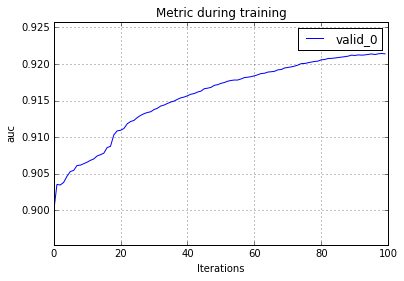

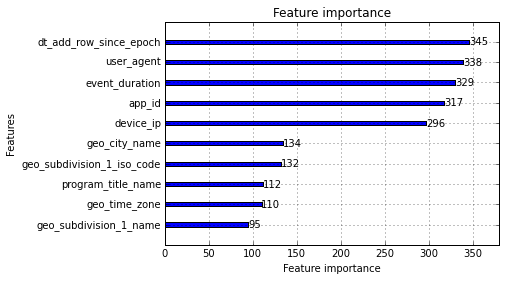

In [79]:
ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()

ax = lgb.plot_importance(bst, max_num_features=10)
plt.show()

### Что можно сделать ещё
* Болле качественный подбор параметров обучения
* Извлечение других фич из датасета ('user_agent', 'dt_add_row')
* Уменьшение размерности (возможно использование PCA) в данном контексте кажется нецелесообразным, скорее всего на точности не повлияет, но можно проверить
* Нарисовать ещё графики, более детальный визуальный анализ данных
* Сделать то же самое, но для каждого отдельного ролика, сделать для этой задачи бинарные классификаторы для каждого ролика и оценить их работу

### Если данных много 

LightGBM и Xgboost рассчитаны на вычисления на больших данных. Но в них нельзя обучать партициями, что означает, если у нас будет сервер со 100 гигами оперативной памяти, мы обучим модель. Если нет, то придется использовать другие методы.

Keras и TensorFlow могут обучаться по партициям, но настройка и обработка данных требуют много времени, кода и не всегда приводят к хорошему результату.

Самым разумным является использовать Spark, желательно на нэтив Scala. При их использовании размеры данных и сложность их обработки неограниченны ничем, кроме времени. К тому же в этом случае, снимается вопрос предварительной обработки больших данных, так как в этом случае всё будет выполняться в том же окружении и последовательно, без перегонов между форматами и хранилищами.